In [385]:
from keras.datasets import fashion_mnist
import wandb
import warnings
warnings.filterwarnings('ignore')
# wandb.login()

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [386]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [387]:
def relu(x):
    return np.maximum(0,x)

def reluPrime(x):
    return 1*(x>0)

In [388]:
def pre_process(x):
    x=x.reshape(-1,784)
    x=x/255
    return x

In [389]:
x_train=pre_process(x_train)
x_test=pre_process(x_test)

In [390]:
class Activation_Functions:
    def __init__(self,function):
        self.function=function
    def getActivations(self,x):
        if self.function=='relu':
            return np.maximum(0,x)
        elif self.function=='sigmoid':
            return 1.0/(1+np.exp(-x))
        elif self.function=='tanh':
            return np.tanh(x)
    def getDerivatives(self,x):
        if self.function=='relu':
             return 1*(x>0)
        elif self.function=='sigmoid':
            return sigmoid(x)*(1-sigmoid(x))
        elif self.function=='tanh':
            return (1 - (np.tanh(x)**2))         

In [391]:
class Optimizers:
    def __init__(self,method):
        self.method=method
    def update(self,obj,lr,momentum=0.9):
        if self.method=='sgd':
            for i in range(len(obj.layers)):
                obj.weights[i]=obj.weights[i]-lr*obj.gradients_w[i]
                obj.biases[i]=obj.biases[i]-lr*obj.gradients_b[i]
        elif self.method=='momentum':
            init=0
            new_gradients=[None]*len(obj.gradients_w)
            for i in range(len(obj.layers)):
                if obj.prev_gradients_w!=None:
                    new_gradients[i]=lr*obj.gradients_w[i]+obj.prev_gradients_w[i]*momentum
                else:
                    new_gradients[i]=lr*obj.gradients_w[i]
                    
                obj.weights[i]=obj.weights[i]-lr*new_gradients[i]
            obj.prev_gradients_w=new_gradients
            
            
            pass
        elif self.method=='rmsprop':
            pass
        elif self.method=='adam':
            pass
        elif self.method=='nadam':
            pass
        elif self.method=='nag':
            pass        

In [392]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def sigmoidPrime(x):
    return sigmoid(x)*(1-sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanhPrime(x):
    return (1 - (np.tanh(x)**2))

In [393]:
def intialize_weights(method,rows,cols):
    if method=='uniform':
        return np.random.rand(rows,cols)
    elif method=='xavier':
        return np.random.randn(rows,cols)*np.sqrt(2/(rows+cols))
    else:
        return np.random.randn(rows,cols)

In [394]:
def soft_max(x):
#     return np.exp(x)/np.sum(np.exp(x),axis=0)
#     min_=np.min(x,axis=0)
    max_=np.max(x,axis=0)

    x=x-max_
    
#     x=(x-min_)/(max_-min_)
    return np.exp(x)/np.sum(np.exp(x),axis=0)

In [395]:
def soft_max_prime(x):
    return soft_max(x)*(1-soft_max(x))
    

In [396]:
class OneHotEncoder:
    def __init__(self,max_):
        self.max_=max_
    def transform(self,x):
        out=np.zeros((len(x),self.max_))
        out[np.arange(len(x)),x]=1
        return out.T

In [407]:
def cross_entropy_loss(y_pre,y):
#     y_pre[y_pre<1e-15]=1e-15
    loss=-np.sum(y*np.log(y_pre))
    return loss/float(y_pre.shape[1])

In [398]:
def getSig():
    return lambda x:1.0/(1+np.exp(-x))

In [399]:
# best: batch_size=32 sgd sigmoid xavier 87/86

In [408]:
class NN:
    def __init__(self,input_size,layers,active_func='sigmoid',weights_init='xavier'):
        self.input_size=input_size
        self.layers=layers
        self.nlayers=len(layers)
        self.activations=Activation_Functions(active_func)
        self.optimizer=Optimizers('sgd')
        self.weights=[]
        self.weights.append(intialize_weights(weights_init,layers[0],input_size))
        self.deltas=[None]*self.nlayers
        self.gradients_w=[None]*self.nlayers
        self.gradients_b=[None]*self.nlayers
        self.prev_gradients_w=None
        
        
        self.biases=[]
        for i in range(1,len(layers)):
            self.weights.append(intialize_weights(weights_init,layers[i],layers[i-1]))
        for i in range(len(layers)):
            self.biases.append(np.random.randn(layers[i],1))                              
    def forward(self,x):
        layer_outputs=[]
        inter_values=[]
        
        for i in range(len(self.weights)):
            inter_values.append(self.weights[i].dot(x)+self.biases[i])
            if i!= len(self.weights)-1:
                layer_outputs.append(self.activations.getActivations(inter_values[-1]))
                x=layer_outputs[-1]
        layer_outputs.append(soft_max(inter_values[-1]))
        return layer_outputs,inter_values
    def compute_deltas(self,layer_outputs,inter_values,y_one_hot):
#         self.deltas[self.nlayers-1]=(layer_outputs[self.nlayers-1]-y_one_hot)*soft_max_prime(inter_values[self.nlayers-1])
        self.deltas[self.nlayers-1]=(layer_outputs[self.nlayers-1]-y_one_hot)
        
        for i in range(self.nlayers-2,-1,-1):
            self.deltas[i]=np.matmul(self.weights[i+1].T,self.deltas[i+1])*self.activations.getDerivatives(inter_values[i])
        
    def find_gradients(self,x,layer_outs):
        self.gradients_w[0]=np.matmul(self.deltas[0],x.T)/batch_size
        for i in range(1,self.nlayers):
            self.gradients_w[i]=(np.dot(self.deltas[i],layer_outs[i-1].T))/batch_size
        for i in range(self.nlayers):
            self.gradients_b[i]=np.sum(self.deltas[i],keepdims=True)/batch_size
        
            
    def update_weights(self,lr):
        for each in range(self.nlayers):
            self.optimizer.update(self,lr=0.1)
            
    def train(self,x,y,epochs=1):
        losses=[]
        for epoch in range(epochs):
            self.prev_gradients_w=None
            i=0
            batch_count=0
            loss=0
            while i+batch_size < x.shape[1]:
                batch_count+=1
                x_batch=x[:,i:i+batch_size]
                y_batch=y[:,i:i+batch_size]
                i+=batch_size
                layer_outs,inter_values=self.forward(x_batch)
                loss+=cross_entropy_loss(layer_outs[-1],y_batch)
                self.compute_deltas(layer_outs,inter_values,y_batch)
                self.find_gradients(x_batch,layer_outs)
                self.optimizer.update(self,0.1,0.1)
            losses.append(loss/batch_count)
            print(f"epoch {epoch+1} : loss = {loss/batch_count}")
        return losses
    
    def predict_probas(self,x):
        layer_outs,inter_values=self.forward(x)
        return layer_outs[-1]
        

In [409]:
batch_size=32
sample=60000
x_tr=x_train[:sample]

y_tr=y_train[:sample]

one_hot=OneHotEncoder(10)
one_hot_y=one_hot.transform(y_tr)

In [410]:
# def main():
#     obj =NN(784,[128,128,128,10],'sigmoid','normal')
#     obj.train(x_tr.T,one_hot_y,10)
    
    

In [411]:
obj =NN(784,[32,32,32,10],'sigmoid','xavier')
losses=obj.train(x_tr.T,one_hot_y,20)

epoch 1 : loss = 1.7516094626818934
epoch 2 : loss = 0.9443348870465917
epoch 3 : loss = 0.6700867226446611
epoch 4 : loss = 0.5549557600437093
epoch 5 : loss = 0.4880616235833139
epoch 6 : loss = 0.4486474134906836
epoch 7 : loss = 0.4231085713274214
epoch 8 : loss = 0.40383511545231177
epoch 9 : loss = 0.3882438655487034
epoch 10 : loss = 0.3751339167803841
epoch 11 : loss = 0.363776348759616
epoch 12 : loss = 0.3538697979017372
epoch 13 : loss = 0.34523927779554575
epoch 14 : loss = 0.33763902458181827
epoch 15 : loss = 0.3308426217144081
epoch 16 : loss = 0.3246982552455426
epoch 17 : loss = 0.3190954862242686
epoch 18 : loss = 0.31394765054112117
epoch 19 : loss = 0.3091865169064473
epoch 20 : loss = 0.30475908417948994


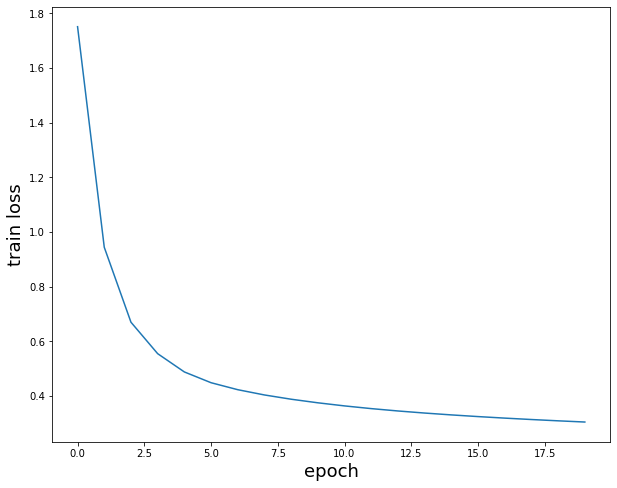

In [412]:
plt.figure(figsize=(10,8))
plt.plot(losses)
plt.xlabel("epoch",fontsize=18)
plt.ylabel("train loss",fontsize=18)
plt.show()

In [413]:

out=obj.predict_probas(x_tr.T)
pred=np.argmax(out,axis=0)
print(classification_report(pred,y_train.flatten()))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      6984
           1       0.99      0.95      0.97      6240
           2       0.85      0.79      0.82      6401
           3       0.90      0.89      0.89      6055
           4       0.85      0.81      0.83      6281
           5       0.97      0.98      0.97      5928
           6       0.56      0.82      0.67      4079
           7       0.98      0.93      0.95      6322
           8       0.97      0.98      0.97      5980
           9       0.94      0.99      0.96      5730

    accuracy                           0.89     60000
   macro avg       0.89      0.89      0.89     60000
weighted avg       0.90      0.89      0.89     60000



In [414]:
out=obj.predict_probas(x_test.T)
pred=np.argmax(out,axis=0)
print(classification_report(pred,y_test.flatten()))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1147
           1       0.97      0.95      0.96      1024
           2       0.80      0.75      0.77      1074
           3       0.87      0.86      0.86      1019
           4       0.81      0.77      0.79      1052
           5       0.94      0.97      0.95       978
           6       0.52      0.77      0.62       679
           7       0.97      0.91      0.94      1062
           8       0.96      0.96      0.96      1003
           9       0.93      0.97      0.95       962

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.88      0.87      0.87     10000

